### Colab Setup

### To select GPU in Google Colab:
- go to **Edit -> Notebook settings -> Hardware accelerator -> GPU**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
# modify "customized_path_to_homework", path of folder in drive, where you uploaded your homework
customized_path_to_homework = "/content/drive/My Drive/DL_Fall_2020/Assignment_3"
sys.path.append(customized_path_to_homework)

In [ ]:
import os
import random
import cv2
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import models
from resnet_yolo import resnet50
from dataset import VocDetectorDataset
from eval_voc import evaluate
from predict import predict_image
from config import VOC_CLASSES, COLORS
import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Initialization

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#print(torch.cuda.get_device_name()) # GPU name

# You Only Look Once: Unified, Real-Time Object Detection 
In this assignment, you need to implement the loss function and train the **YOLO object detector** (specfically, YOLO-v1). Here we provide a list of recommend readings for you:
- [YOLO original paper](https://arxiv.org/pdf/1506.02640.pdf) (recommended)
- [Object detection methods](http://slazebni.cs.illinois.edu/fall18/lec09_detection.pdf) (Slides)
- [Great post about YOLO](https://medium.com/adventures-with-deep-learning/yolo-v1-part-1-cfb47135f81f) on Medium
- [Differences between YOLO, YOLOv2 and YOLOv3
](https://medium.com/@jonathan_hui/real-time-object-detection-with-yolo-yolov2-28b1b93e2088)
- [Great explanation of the Yolo Loss function](https://stats.stackexchange.com/questions/287486/yolo-loss-function-explanation)

We adopt a variant of YOLO, which:
1. Use pretrained ResNet50 classifier as detector backbone. The pretrained model is offered in `torchvision.models`.
2. Instead of using a $7\times7$ detection grid, we use $14\times14$ to get a more finegrained detection.

In general, the backbone models are usually pretrained on ImageNet dataset (> 1 million images) with numerous classes. As a result, having these pretrained backbone can greatly shorten the required training time, as well as improve the performance. <span style="color:red">**But still, it takes at least 3-4 hours to train, not to mention that you might need to debug after one training run. So START EARLY, DON'T GO #YOLO!**</span>

<img src="figure/example.png" width="450">
You are supposed to get a reasonable detector (like the ... above?) after training the model correctly.

In [ ]:
# YOLO network hyperparameters
B = 2  # number of bounding box predictions per cell
S = 14  # width/height of network output grid (larger than 7x7 from paper since we use a different network)

## Load the pretrained ResNet classifier
Load the pretrained classifier. By default, it would use the pretrained model provided by `Pytorch`.

In [ ]:
load_network_path = None
pretrained = True

# use to load a previously trained network
if load_network_path is not None:
    print('Loading saved network from {}'.format(load_network_path))
    net = resnet50().to(device)
    net.load_state_dict(torch.load(load_network_path))
else:
    print('Load pre-trained model')
    net = resnet50(pretrained=pretrained).to(device)

Load pre-trained model


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


Some basic hyperparameter settings that you probably don't have to tune.

In [ ]:
learning_rate = 0.001
num_epochs = 50
batch_size = 24

# Yolo loss component coefficients (as given in Yolo v1 paper)
lambda_coord = 5
lambda_noobj = 0.5

## Implement the YOLO-v1 loss 
Now, you have to implement the `YoloLoss` for training your object detector. Please read closely to the [YOLO original paper](https://arxiv.org/pdf/1506.02640.pdf) so that you can implement it.

In general, there are 4 components in the YOLO loss. Consider that we have our prediction grid of size$(N, S, S, 5B+c)$ ( (x, y, w, h, C) for each bounding box, and c is the number of classes), where $N$ is the batch size, $S$ is the grid size, $B$ is the number of bounding boxes. We have :
1. Bounding box regression loss on the bounding box$(x, y, w, h)$
    - $l_{coord}=\sum_{i=0}^{S^2}\sum_{j=0}^B\mathbb{1}^{obj}_{ij}\left[(x_i-\hat{x}_i)^2+(y_i-\hat{y}_i)^2\right]$ + $\sum_{i=0}^{S^2}\sum_{j=0}^B\mathbb{1}^{obj}_{ij}\left[(\sqrt{w_i}-\sqrt{\hat{w}_i})^2+(\sqrt{h_i}-\sqrt{\hat{h}_i})^2\right]$
    - $\mathbb{1}^{obj}_{ij}$: equals to 1 when object appears in cell $i$, and the bounding box $j$ is responsible for the prediction. 0 otherwise.
2. Contain object loss on the confidence prediction $c$ (only calculate for those boxes that actually have objects)
    - $l_{contain}=\sum_{i=0}^{S^2}\sum_{j=0}^B\mathbb{1}^{obj}_{ij}(C_i-\hat{C}_i)^2$
    - $C_i$ the predicted confidence score for cell $i$ from predicted box $j$
    - For each grid cell, you only calculate the contain object loss for the predicted bounding box that has maximum overlap (iou) with the gruond truth box.
    - We say that this predicted box with maximum iou is **responsible** for the prediction.
3. No object loss on the confidence prediction $c$ (only calculate for those boxes that don't have objects)
    - $l_{noobj}=\sum_{i=0}^{S^2}\sum_{j=0}^B\mathbb{1}^{noobj}_{ij}(C_i-\hat{C}_i)^2$
    - $\mathbb{1}^{obj}_{ij}$: equals to 1 when **no object appears** in cell $i$.
4. Classification error loss.
    - $l_{class}=\sum_{i=0}^{S^2}\mathbb{1}_i^{obj}\sum_{c\in classes}\left(p_i(c)-\hat{p_i}(c)\right)^2$
    - $p_i(c)$ is the predicted score for class $c$
    
Putting them together, we get the yolo loss:
\begin{equation}
yolo=\lambda_{coord}l_{coord}+l_{contain}+\lambda_{noobj}l_{noobj}+l_{class}
\end{equation}
where $\lambda$ are hyperparameters. We have provided detailed comments to guide you through implementing the loss. So now, please complete the YoloLoss in the code block below. **If you have any problem with regard to implementation, post and discuss it on Piazza.**

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
 
class YoloLoss(nn.Module):
    def __init__(self,S,B,l_coord,l_noobj):
        super(YoloLoss,self).__init__()
        self.S = S
        self.B = B
        self.l_coord = l_coord
        self.l_noobj = l_noobj
 
    def compute_iou(self, box1, box2):                                                                                                                                                             
        """Compute the intersection over union of two set of boxes, each box is 
        [x1,y1,x2,y2].
        Args:
          box1: (tensor) bounding boxes, sized [N,4].
          box2: (tensor) bounding boxes, sized [M,4].
        Return:
          (tensor) iou, sized [N,M].
        """
        N = box1.size(0)
        M = box2.size(0)
 
        lt = torch.max(
            box1[:,:2].unsqueeze(1).expand(N,M,2),  # [N,2] -> [N,1,2] -> [N,M,2]
            box2[:,:2].unsqueeze(0).expand(N,M,2),  # [M,2] -> [1,M,2] -> [N,M,2]
        )   
 
        rb = torch.min(
            box1[:,2:].unsqueeze(1).expand(N,M,2),  # [N,2] -> [N,1,2] -> [N,M,2]
            box2[:,2:].unsqueeze(0).expand(N,M,2),  # [M,2] -> [1,M,2] -> [N,M,2]
        )   
 
        wh = rb - lt  # [N,M,2]
        wh[wh<0] = 0  # clip at 0
        inter = wh[:,:,0] * wh[:,:,1]  # [N,M]
 
        area1 = (box1[:,2]-box1[:,0]) * (box1[:,3]-box1[:,1])  # [N,]
        area2 = (box2[:,2]-box2[:,0]) * (box2[:,3]-box2[:,1])  # [M,]
        area1 = area1.unsqueeze(1).expand_as(inter)  # [N,] -> [N,1] -> [N,M]
        area2 = area2.unsqueeze(0).expand_as(inter)  # [M,] -> [1,M] -> [N,M]
 
        iou = inter / (area1 + area2 - inter)
        return iou 
    
    def get_class_prediction_loss(self, classes_pred, classes_target):
        """ 
        Parameters:
        classes_pred : (tensor) size (batch_size, S, S, 20)                                                                                                                                        
        classes_target : (tensor) size (batch_size, S, S, 20)
         
        Returns:
        class_loss : scalar
        """
        ##### CODE #####
       
        class_loss = F.mse_loss(classes_pred,classes_target,size_average=False)

        ##### CODE #####
        return class_loss
         
         
    def get_regression_loss(self, box_pred_response, box_target_response):
        """
        Parameters:
        box_pred_response : (tensor) size (-1, 5)
        box_target_response : (tensor) size (-1, 5)
        Note : -1 corresponds to ravels the tensor into the dimension specified 
        See : https://pytorch.org/docs/stable/tensors.html#torch.Tensor.view_as
         
        Returns:
        reg_loss : scalar
        """
        ##### CODE #####
        #mean square loss difference for the box predictied response and the target response
        reg_loss = F.mse_loss(box_pred_response[:,:2],box_target_response[:,:2],size_average=False) 
        + F.mse_loss(torch.sqrt(box_pred_response[:,2:4]),torch.sqrt(box_target_response[:,2:4]),size_average=False)
        ##### CODE #####
        return reg_loss
         
    def get_contain_object_loss(self, box_pred_response, box_target_response_iou):
        """
        Parameters:
        box_pred_response : (tensor) size ( -1 , 5)
        box_target_response_iou : (tensor) size ( -1 , 5)
        Note : -1 corresponds to ravels the tensor into the dimension specified 
        See : https://pytorch.org/docs/stable/tensors.html#torch.Tensor.view_as
         
        Returns:
        contain_loss : scalar
        """
        ##### CODE #####
        # loss b/w the predicted box response and the box iou response
        contain_loss = F.mse_loss(box_pred_response[:,4],box_target_response_iou[:,4],size_average=False)
        
        ##### CODE #####
        return contain_loss
         
    def get_no_object_loss(self, target_tensor, pred_tensor):
        """                                                                                                                                                                                        
        Parameters:
        target_tensor : (tensor) size (batch_size, S , S, 30)
        pred_tensor : (tensor) size (batch_size, S , S, 30)
        no_object_mask : (tensor) size (batch_size, S , S)
         
        Returns:
        no_object_loss : scalar
         
        Hints:
        1) Create 2 tensors no_object_prediction and no_object_target which only have the 
        values which have no object. 
        2) Have another tensor no_object_prediction_mask of the same size such that 
        mask with respect to both confidences of bounding boxes set to 1. 
        3) Create 2 tensors which are extracted from no_object_prediction and no_object_target using
        the mask created above to find the loss. 
        """
        ##### CODE #####
        #no object prediction tensor - noo_pred
        #no object target target tensor - noo_target
        N = pred_tensor.size()[0]      
        noo_mask = target_tensor[:,:,:,4] == 0        
        noo_mask = noo_mask.unsqueeze(-1).expand_as(target_tensor)
                    

        # compute not contain obj loss
        noo_pred = pred_tensor[noo_mask].view(-1,30)
        noo_target = target_tensor[noo_mask].view(-1,30)          
        noo_pred_mask = torch.cuda.ByteTensor(noo_pred.size())         #mask of the no object prediction
        noo_pred_mask.zero_()
        noo_pred_mask[:,4]=1; noo_pred_mask[:,9]=1          #mask tensor setting the confidence of bounding boxes to 1 
        noo_pred_c = noo_pred[noo_pred_mask] #noo pred size[-1,2]             # tensor extracted from the mask tensors
        noo_target_c = noo_target[noo_pred_mask]
        no_object_loss = F.mse_loss(noo_pred_c,noo_target_c,size_average=False)
        

        ##### CODE #####
        return no_object_loss
          
    def find_best_iou_boxes(self, box_target, box_pred):
        """
        Parameters: 
        box_target : (tensor)  size (-1, 5)
        box_pred : (tensor) size (-1, 5)
        Note : -1 corresponds to ravels the tensor into the dimension specified 
        See : https://pytorch.org/docs/stable/tensors.html#torch.Tensor.view_as
         
        Returns: 
        box_target_iou: (tensor)
        contains_object_response_mask : (tensor)
         
        Hints:
        1) Find the iou's of each of the 2 bounding boxes of each grid cell of each image.
        2) Set the corresponding contains_object_response_mask of the bounding box with the max iou
        of the 2 bounding boxes of each grid cell to 1.
        3) For finding iou's use the compute_iou function
        4) Before using compute preprocess the bounding box coordinates in such a way that 
        if for a Box b the coordinates are represented by [x, y, w, h] then 
        x, y = x/S - 0.5*w, y/S - 0.5*h ; w, h = x/S + 0.5*w, y/S + 0.5*h
        Note: Over here initially x, y are the center of the box and w,h are width and height. 
        We perform this transformation to convert the correct coordinates into bounding box coordinates.
        5) Set the confidence of the box_target_iou of the bounding box to the maximum iou
        """
        # S = 14 - width/height of network output grid
        ##### CODE #####
         #compute contain obj loss
         #contains object response mask tesnsor - coo_response_maks
        coo_response_mask = torch.cuda.ByteTensor(box_target.size())
        coo_response_mask.zero_()
        coo_not_response_mask = torch.cuda.ByteTensor(box_target.size())
        coo_not_response_mask.zero_()
        box_target_iou = torch.zeros(box_target.size()).cuda()
        for i in range(0,box_target.size()[0],2): #choose the best iou box
            box1 = box_pred[i:i+2]
            box1_xy = Variable(torch.FloatTensor(box1.size()))
            box1_xy[:,:2] = box1[:,:2]/14. -0.5*box1[:,2:4]    #coordinate x,y for box 1
            box1_xy[:,2:4] = box1[:,:2]/14. +0.5*box1[:,2:4]    #coordinate w,h for box 1
            box2 = box_target[i].view(-1,5)
            box2_xy = Variable(torch.FloatTensor(box2.size()))
            box2_xy[:,:2] = box2[:,:2]/14. -0.5*box2[:,2:4]     #coordinate x,y for box 2
            box2_xy[:,2:4] = box2[:,:2]/14. +0.5*box2[:,2:4]     #coordinate w,h for box 2
            iou = self.compute_iou(box1_xy[:,:4],box2_xy[:,:4]) #[2,1]   #compute intersection over union
            max_iou,max_index = iou.max(0)     #setting confidence to maximum iou
            max_index = max_index.data.cuda()                  
            
            coo_response_mask[i+max_index]=1
            coo_not_response_mask[i+1-max_index]=1

            #####
            # we want the confidence score to equal the
            # intersection over union (IOU) between the predicted box
            # and the ground truth
            #####
            box_target_iou[i+max_index,torch.LongTensor([4]).cuda()] = (max_iou).data.cuda()
        box_target_iou = Variable(box_target_iou).cuda() 
        ##### CODE #####
        return box_target_iou, coo_response_mask
         
    def forward(self, pred_tensor,target_tensor):
        '''
        pred_tensor: (tensor) size(batchsize,S,S,Bx5+20=30)
                      where B - number of bounding boxes this grid cell is a part of = 2
                            5 - number of bounding box values corresponding to [x, y, w, h, c]
                                where x - x_coord, y - y_coord, w - width, h - height, c - confidence of having an object
                            20 - number of classes
         
        target_tensor: (tensor) size(batchsize,S,S,30)
         
        Returns:
        Total Loss
        '''
        N = pred_tensor.size(0)
         
        total_loss = None
        # Create 2 tensors contains_object_mask and no_object_mask 
        # of size (Batch_size, S, S) such that each value corresponds to if the confidence of having 
        # an object > 0 in the target tensor.

        ##### CODE #####
        coo_mask = target_tensor[:,:,:,4] > 0       
        noo_mask = target_tensor[:,:,:,4] == 0
        coo_mask = coo_mask.unsqueeze(-1).expand_as(target_tensor)    # mask for contains object tensor
        noo_mask = noo_mask.unsqueeze(-1).expand_as(target_tensor)     #mask for no object tensor

        ##### CODE #####
        """
        Create a tensor contains_object_pred that corresponds to 
        to all the predictions which seem to confidence > 0 for having an object
        Then, split this tensor into 2 tensors :                                                                                                                                                       
        1) bounding_box_pred : Contains all the Bounding box predictions (x, y, w, h, c) of all grid 
                                cells of all images
        2) classes_pred : Contains all the class predictions for each grid cell of each image
        Hint : Use contains_object_mask
        """ 
        ##### CODE #####
        coo_pred = pred_tensor[coo_mask].view(-1,30)
        box_pred = coo_pred[:,:10].contiguous().view(-1,5) # tensor for all box predictions
        classes_pred = coo_pred[:,10:]                       #tensor for all class predictions
        ##### CODE #####                   
        """
        # Similarly, create 2 tensors bounding_box_target and classes_target
        # using the contains_object_mask.
        """
        ##### CODE #####
        coo_target = target_tensor[coo_mask].view(-1,30)
        box_target = coo_target[:,:10].contiguous().view(-1,5)
        classes_target = coo_target[:,10:]
        ##### CODE #####
        
        #Compute the No object loss here
        # Instruction: finish your get_no_object_loss
        ##### CODE #####
        no_object_loss = self.get_no_object_loss(target_tensor, pred_tensor)         #no object loss on condidence prediction
        ##### CODE #####
        """
        # Compute the iou's of all bounding boxes and the mask for which bounding box 
        # of 2 has the maximum iou the bounding boxes for each grid cell of each image.
        # Instruction: finish your find_best_iou_boxes and use it.
        """
        ##### CODE #####
        box_best = self.find_best_iou_boxes(box_target, box_pred)
        box_target_iou = box_best[0]
        coo_response_mask = box_best[1]
        ##### CODE #####
        """        
        # Create 3 tensors :
        # 1) box_prediction_response - bounding box predictions for each grid cell which has the maximum iou
        # 2) box_target_response_iou - bounding box target ious for each grid cell which has the maximum iou
        # 3) box_target_response -  bounding box targets for each grid cell which has the maximum iou
        # Hint : Use coo_response_mask
        """
        ##### CODE #####
        box_pred_response = box_pred[coo_response_mask].view(-1,5)
        box_target_response_iou = box_target_iou[coo_response_mask].view(-1,5)
        box_target_response = box_target[coo_response_mask].view(-1,5)
        ##### CODE #####
        """
        # Find the class_loss, containing object loss and regression loss
        """
        ##### CODE #####
        class_loss = self.get_class_prediction_loss(classes_pred, classes_target)                #classification error loss
        contain_loss = self.get_contain_object_loss(box_pred_response, box_target_response_iou)  #contain object loss
        reg_loss = self.get_regression_loss(box_pred_response, box_target_response)    #bounding box regression loss

        total_loss = self.l_coord*reg_loss + contain_loss + self.l_noobj*no_object_loss + class_loss
        

        ##### CODE #####
        return total_loss / N

In [ ]:
criterion = YoloLoss(S, B, lambda_coord, lambda_noobj)
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

## Reading Pascal Data

Since Pascal is a small dataset (5000 in train+val) we have combined the train and val splits to train our detector. This is not typically a good practice, but we will make an exception in this case to be able to get reasonable detection results with a comparatively small object detection dataset. Use `download_data.sh` to download the dataset.

The train dataset loader also using a variety of data augmentation techniques including random shift, scaling, crop, and flips. Data augmentation is slightly more complicated for detection dataset since the bounding box annotations must be kept consistent through the transformations.

Since the output of the dector network we train is a $(S, S, 5B+c)$ tensor, we use an encoder to convert the original bounding box coordinates into relative grid bounding box coordinates corresponding to the the expected output. We also use a decoder which allows us to convert the opposite direction into image coordinate bounding boxes.

In [ ]:
file_root_train = customized_path_to_homework + '/VOCdevkit_2007/VOC2007/JPEGImages/'
annotation_file_train = customized_path_to_homework + '/voc2007.txt'

train_dataset = VocDetectorDataset(root_img_dir=file_root_train,dataset_file=annotation_file_train,train=True, S=S)
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=4)
print('Loaded %d train images' % len(train_dataset))

Initializing dataset
Loaded 5011 train images


In [ ]:
file_root_test = customized_path_to_homework + '/VOCdevkit_2007/VOC2007test/JPEGImages/'
annotation_file_test = customized_path_to_homework + '/voc2007test.txt'

test_dataset = VocDetectorDataset(root_img_dir=file_root_test,dataset_file=annotation_file_test,train=False, S=S)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False,num_workers=4)
print('Loaded %d test images' % len(test_dataset))

Initializing dataset
Loaded 4950 test images


In [ ]:
 import torch
 torch.cuda.empty_cache()

## Train detector
Now, train your detector.

In [ ]:
learning_rate = 0.001
num_epochs = 50
batch_size =  24

# Yolo loss component coefficients (as given in Yolo v1 paper)
lambda_coord = 5
lambda_noobj = 0.5

In [ ]:
best_test_loss = np.inf

for epoch in range(num_epochs):
    net.train()
    
    # Update learning rate late in training
    if epoch == 30 or epoch == 40:
        learning_rate /= 10.0

    for param_group in optimizer.param_groups:
        param_group['lr'] = learning_rate
    
    print('\n\nStarting epoch %d / %d' % (epoch + 1, num_epochs))
    print('Learning Rate for this epoch: {}'.format(learning_rate))
    
    total_loss = 0.
    
    for i, (images, target) in enumerate(tqdm(train_loader, total=len(train_loader))):
        images, target = images.to(device), target.to(device)

        pred = net(images)
        loss = criterion(pred,target)
        total_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print('Epoch [%d/%d], average_loss: %.4f'
            % (epoch+1, num_epochs, total_loss / (i+1)))
    
    # evaluate the network on the test data
    with torch.no_grad():
        test_loss = 0.0
        net.eval()
        for i, (images, target) in enumerate(tqdm(test_loader, total=len(test_loader))):
            images, target = images.to(device), target.to(device)

            pred = net(images)
            loss = criterion(pred,target)
            test_loss += loss.item()
        test_loss /= len(test_loader)
    
    if best_test_loss > test_loss:
        best_test_loss = test_loss
        print('Updating best test loss: %.5f' % best_test_loss)
        torch.save(net.state_dict(),'best_detector.pth')

    torch.save(net.state_dict(),'detector.pth')

  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 1 / 50
Learning Rate for this epoch: 0.001


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:71: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:20.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:72: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:20.)
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:105: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:20.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10

Epoch [1/50], average_loss: 11.1540


100%|██████████| 207/207 [09:25<00:00,  2.73s/it]


Updating best test loss: 6.34178


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 2 / 50
Learning Rate for this epoch: 0.001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [2/50], average_loss: 5.8715


100%|██████████| 207/207 [01:04<00:00,  3.19it/s]


Updating best test loss: 5.62206


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 3 / 50
Learning Rate for this epoch: 0.001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [3/50], average_loss: 5.1936


100%|██████████| 207/207 [01:04<00:00,  3.19it/s]


Updating best test loss: 5.18851


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 4 / 50
Learning Rate for this epoch: 0.001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [4/50], average_loss: 4.8771


100%|██████████| 207/207 [01:05<00:00,  3.17it/s]


Updating best test loss: 4.91256


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 5 / 50
Learning Rate for this epoch: 0.001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [5/50], average_loss: 4.6030


100%|██████████| 207/207 [01:05<00:00,  3.17it/s]


Updating best test loss: 4.72749


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 6 / 50
Learning Rate for this epoch: 0.001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [6/50], average_loss: 4.3545


100%|██████████| 207/207 [01:05<00:00,  3.17it/s]


Updating best test loss: 4.44241


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 7 / 50
Learning Rate for this epoch: 0.001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [7/50], average_loss: 4.1895


100%|██████████| 207/207 [01:05<00:00,  3.17it/s]


Updating best test loss: 4.29308


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 8 / 50
Learning Rate for this epoch: 0.001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [8/50], average_loss: 4.0212


100%|██████████| 207/207 [01:05<00:00,  3.17it/s]


Updating best test loss: 4.20671


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 9 / 50
Learning Rate for this epoch: 0.001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [9/50], average_loss: 3.8882


100%|██████████| 207/207 [01:05<00:00,  3.16it/s]


Updating best test loss: 4.05450


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 10 / 50
Learning Rate for this epoch: 0.001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [10/50], average_loss: 3.7517


100%|██████████| 207/207 [01:05<00:00,  3.14it/s]


Updating best test loss: 4.03240


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 11 / 50
Learning Rate for this epoch: 0.001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [11/50], average_loss: 3.6290


100%|██████████| 207/207 [01:05<00:00,  3.15it/s]


Updating best test loss: 3.89848


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 12 / 50
Learning Rate for this epoch: 0.001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [12/50], average_loss: 3.5797


100%|██████████| 207/207 [01:05<00:00,  3.17it/s]


Updating best test loss: 3.82365


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 13 / 50
Learning Rate for this epoch: 0.001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [13/50], average_loss: 3.4861


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 14 / 50
Learning Rate for this epoch: 0.001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [14/50], average_loss: 3.3646


100%|██████████| 207/207 [01:05<00:00,  3.16it/s]


Updating best test loss: 3.79427


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 15 / 50
Learning Rate for this epoch: 0.001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [15/50], average_loss: 3.3459


100%|██████████| 207/207 [01:05<00:00,  3.18it/s]


Updating best test loss: 3.74145


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 16 / 50
Learning Rate for this epoch: 0.001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [16/50], average_loss: 3.2683


100%|██████████| 207/207 [01:04<00:00,  3.19it/s]


Updating best test loss: 3.67966


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 17 / 50
Learning Rate for this epoch: 0.001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [17/50], average_loss: 3.1737


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 18 / 50
Learning Rate for this epoch: 0.001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [18/50], average_loss: 3.1842


100%|██████████| 207/207 [01:05<00:00,  3.17it/s]


Updating best test loss: 3.65752


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 19 / 50
Learning Rate for this epoch: 0.001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [19/50], average_loss: 3.0995


100%|██████████| 207/207 [01:05<00:00,  3.16it/s]


Updating best test loss: 3.65448


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 20 / 50
Learning Rate for this epoch: 0.001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [20/50], average_loss: 3.0436


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 21 / 50
Learning Rate for this epoch: 0.001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [21/50], average_loss: 3.0295


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 22 / 50
Learning Rate for this epoch: 0.001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [22/50], average_loss: 2.9523


100%|██████████| 207/207 [01:05<00:00,  3.17it/s]


Updating best test loss: 3.64280


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 23 / 50
Learning Rate for this epoch: 0.001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [23/50], average_loss: 2.9121


100%|██████████| 207/207 [01:05<00:00,  3.16it/s]


Updating best test loss: 3.56153


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 24 / 50
Learning Rate for this epoch: 0.001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [24/50], average_loss: 2.9352


100%|██████████| 207/207 [01:05<00:00,  3.18it/s]


Updating best test loss: 3.55369


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 25 / 50
Learning Rate for this epoch: 0.001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [25/50], average_loss: 2.8209


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 26 / 50
Learning Rate for this epoch: 0.001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [26/50], average_loss: 2.8323


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 27 / 50
Learning Rate for this epoch: 0.001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [27/50], average_loss: 2.7887


100%|██████████| 207/207 [01:05<00:00,  3.16it/s]


Updating best test loss: 3.51977


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 28 / 50
Learning Rate for this epoch: 0.001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [28/50], average_loss: 2.7442


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 29 / 50
Learning Rate for this epoch: 0.001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [29/50], average_loss: 2.7530


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 30 / 50
Learning Rate for this epoch: 0.001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [30/50], average_loss: 2.7216


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 31 / 50
Learning Rate for this epoch: 0.0001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [31/50], average_loss: 2.6040


100%|██████████| 207/207 [01:05<00:00,  3.17it/s]


Updating best test loss: 3.45095


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 32 / 50
Learning Rate for this epoch: 0.0001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [32/50], average_loss: 2.5634


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 33 / 50
Learning Rate for this epoch: 0.0001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [33/50], average_loss: 2.5356


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 34 / 50
Learning Rate for this epoch: 0.0001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [34/50], average_loss: 2.5456


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 35 / 50
Learning Rate for this epoch: 0.0001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [35/50], average_loss: 2.5238


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 36 / 50
Learning Rate for this epoch: 0.0001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [36/50], average_loss: 2.4974


100%|██████████| 207/207 [01:05<00:00,  3.16it/s]


Updating best test loss: 3.45059


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 37 / 50
Learning Rate for this epoch: 0.0001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [37/50], average_loss: 2.5010


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 38 / 50
Learning Rate for this epoch: 0.0001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [38/50], average_loss: 2.4965


100%|██████████| 207/207 [01:05<00:00,  3.17it/s]


Updating best test loss: 3.44836


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 39 / 50
Learning Rate for this epoch: 0.0001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [39/50], average_loss: 2.4718


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 40 / 50
Learning Rate for this epoch: 0.0001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [40/50], average_loss: 2.4318


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 41 / 50
Learning Rate for this epoch: 1e-05


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [41/50], average_loss: 2.4386


100%|██████████| 207/207 [01:05<00:00,  3.17it/s]


Updating best test loss: 3.43885


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 42 / 50
Learning Rate for this epoch: 1e-05


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [42/50], average_loss: 2.4217


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 43 / 50
Learning Rate for this epoch: 1e-05


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [43/50], average_loss: 2.4509


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 44 / 50
Learning Rate for this epoch: 1e-05


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [44/50], average_loss: 2.4325


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 45 / 50
Learning Rate for this epoch: 1e-05


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [45/50], average_loss: 2.4513


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 46 / 50
Learning Rate for this epoch: 1e-05


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [46/50], average_loss: 2.4270


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 47 / 50
Learning Rate for this epoch: 1e-05


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [47/50], average_loss: 2.4228


100%|██████████| 207/207 [01:05<00:00,  3.15it/s]


Updating best test loss: 3.43364


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 48 / 50
Learning Rate for this epoch: 1e-05


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [48/50], average_loss: 2.4413


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 49 / 50
Learning Rate for this epoch: 1e-05


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [49/50], average_loss: 2.4560


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 50 / 50
Learning Rate for this epoch: 1e-05


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [50/50], average_loss: 2.4224


100%|██████████| 207/207 [01:06<00:00,  3.13it/s]


# View example predictions

Now, take a glance at how your detector works:

predicting...
(500, 333, 3)


/content/drive/My Drive/DL_Fall_2020/Assignment_3/predict.py:99: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  ids = (ovr<=threshold).nonzero().squeeze()


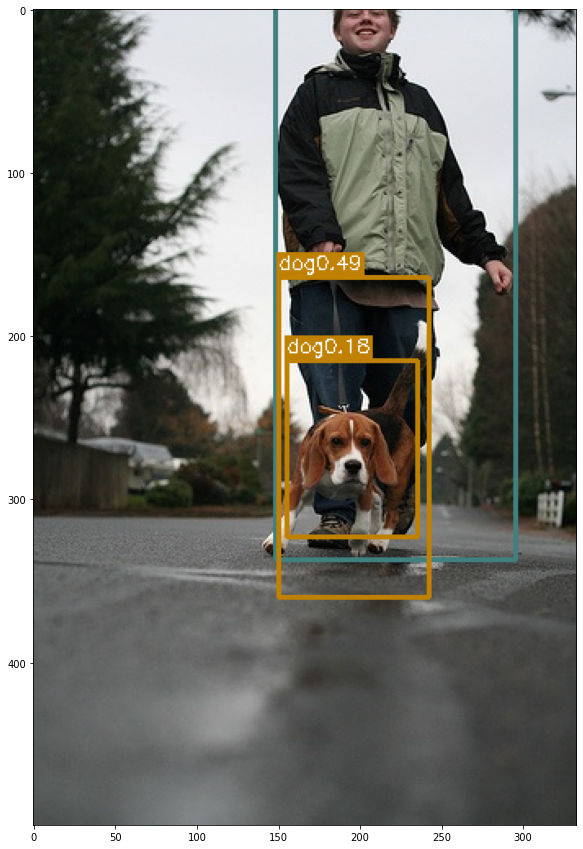

In [ ]:
net.eval()
net.load_state_dict(torch.load('best_detector.pth'))
# select random image from train set
image_name = random.choice(train_dataset.fnames)
image = cv2.imread(os.path.join(file_root_train, image_name))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
threshold = 0.1
print('predicting...')
print(image.shape)
result = predict_image(net, image_name, root_img_directory=file_root_train, threshold=threshold)
for left_up, right_bottom, class_name, _, prob in result:
    color = COLORS[VOC_CLASSES.index(class_name)]
    cv2.rectangle(image, left_up, right_bottom, color, 2)
    label = class_name + str(round(prob, 2))
    text_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
    p1 = (left_up[0], left_up[1] - text_size[1])
    cv2.rectangle(image, (p1[0] - 2 // 2, p1[1] - 2 - baseline), (p1[0] + text_size[0], p1[1] + text_size[1]),
                  color, -1)
    cv2.putText(image, label, (p1[0], p1[1] + baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, 8)

plt.figure(figsize = (15,15))
plt.imshow(image)

## Evaluate on Test
To evaluate detection results we use mAP (mean of average precision over each class), You are expected to get an map of at least 49.

In [ ]:
test_aps = evaluate(net, test_dataset_file=annotation_file_test, threshold=threshold)

---Evaluate model on test samples---


100%|██████████| 4950/4950 [02:25<00:00, 34.04it/s]


---class aeroplane ap 0.5846697038230944---
---class bicycle ap 0.6743452452806984---
---class bird ap 0.612456414297153---
---class boat ap 0.361115163958718---
---class bottle ap 0.2189919717218007---
---class bus ap 0.6058040131793279---
---class car ap 0.7103183873892711---
---class cat ap 0.739696779428669---
---class chair ap 0.33505352502101715---
---class cow ap 0.5942167599897827---
---class diningtable ap 0.4318273426129514---
---class dog ap 0.6869948657422043---
---class horse ap 0.7129128923984352---
---class motorbike ap 0.6743444170334452---
---class person ap 0.6124044015873665---
---class pottedplant ap 0.22135000260053753---
---class sheep ap 0.5487602372571078---
---class sofa ap 0.46965868739295924---
---class train ap 0.7097651802390397---
---class tvmonitor ap 0.5360404302039594---
---map 0.5520363210578769---


In [ ]:
MAP = 55